In [2863]:
import random

import torch
import numpy as np
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

import warnings

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20, 10)

# Autograd

In [2864]:
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [2865]:
func = lambda params: (3 * params[0] ** 4 - params[1] ** 5 + params[0]) / params[0] ** (1 / 4)

func_grad = lambda params: ((45 * params[0] ** 4 + 3 * params[0] + params[1] ** 5) / (4 * params[0] ** (5 / 4)),
                            (-5 * params[1] ** 4) / (params[0] ** (1 / 4)))

func2_simple = lambda params: (3 * params[0] ** 4 - params[1] ** 5 + np.sin(params[0])) / (
        np.log(params[1]) + params[0] ** (1 / 4))
func2_tensor = lambda params: (3 * params[0] ** 4 - params[1] ** 5 + np.sin(params[0].detach().numpy())) / (
        np.log(params[1].detach().numpy()) + params[0] ** (1 / 4))

func2_grad = lambda params: (
    ((12 * params[0] ** 3 + np.cos(params[0])) / (params[0] ** (1 / 4) + np.log(params[1]))) - (
            (3 * params[0] ** 4 + np.sin(params[0]) - params[1] ** 5) / (
            4 * params[0] ** (3 / 4) * (params[0] ** (1 / 4) + np.log(params[1])) ** 2)),
    (-3 * params[0] ** 4 - 5 * params[1] ** 5 * (params[0] ** (1 / 4) + np.log(params[1])) - np.sin(params[0]) + params[
        1] ** 5) / (params[1] * (params[0] ** (1 / 4) + np.log(params[1])) ** 2))

x0 = [9., 3.]

In [2866]:
def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])

In [2867]:
autograd_res = jacobian(func, torch.tensor(x0))
mygrad_res = grad(func, np.array(x0))
expected = func_grad(x0)

print("Autograd: ", autograd_res)
print("Custom: ", mygrad_res)
print("Expected: ", expected)

Autograd:  tensor([4739.3242, -233.8269])
Custom:  [4739.3240493  -233.82686777]
Expected:  (4739.32402221034, -233.82685902179844)


In [2868]:
autograd_res = jacobian(func2_tensor, torch.tensor(x0))
mygrad_res = grad(func2_simple, np.array(x0))
expected = func2_grad(x0)

print("Autograd: ", autograd_res)
print("Custom: ", mygrad_res)
print("Expected: ", expected)

Autograd:  tensor([2973.7107, -143.0760])
Custom:  [2973.38881865 -951.81401321]
Expected:  (2973.388804026748, -951.8140108653779)


# SGD

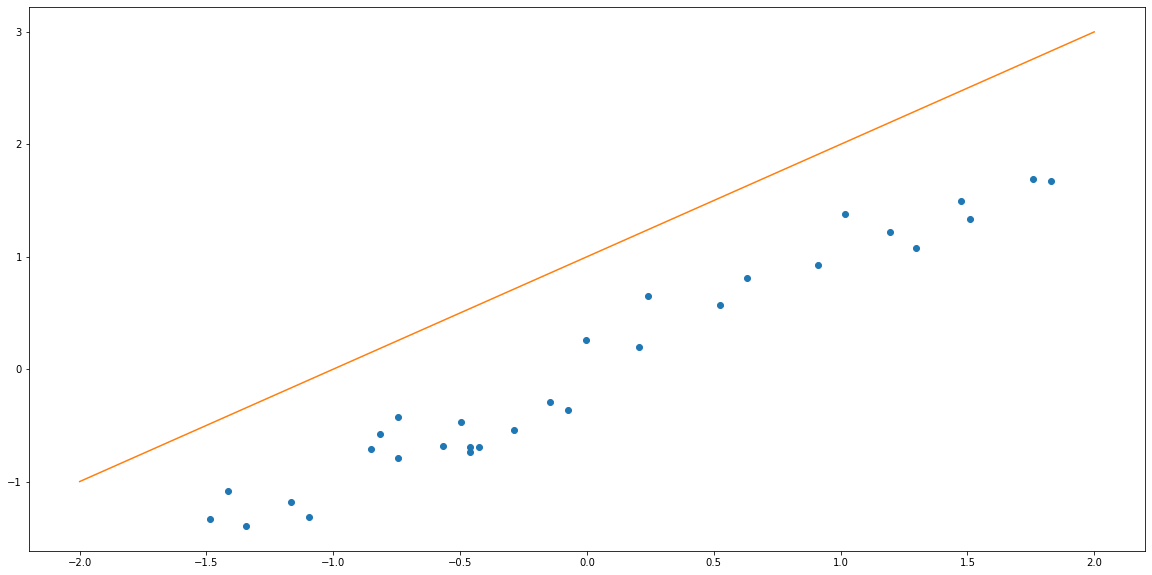

In [2869]:
data = pd.read_csv('Salary_Data.csv')
years = data['YearsExperience']
salary = data['Salary']

avg_exp = years.mean()
dev_exp = years.std()

avg_salary = salary.mean()
dev_salary = salary.std()

years_simple = [(e - avg_exp) / dev_exp for e in years]
salary_simple = [(e - avg_salary) / dev_salary for e in salary]

years = torch.tensor([(e - avg_exp) / dev_exp for e in years])
salary = torch.tensor([(e - avg_salary) / dev_salary for e in salary])

plt.plot(years, salary, 'o')

a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

x = np.linspace(-2, 2, 100)
plt.plot(x, b.data[0] * x + a.data[0])

In [2870]:
optimizer = optim.SGD([a, b], lr=0.2)

loss_list = list()
grads_list = list()

for epoch in range(30):
    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)
    loss.backward()
    optimizer.step()
    grads_list.append(np.linalg.norm([a.grad, b.grad]))
    optimizer.zero_grad()

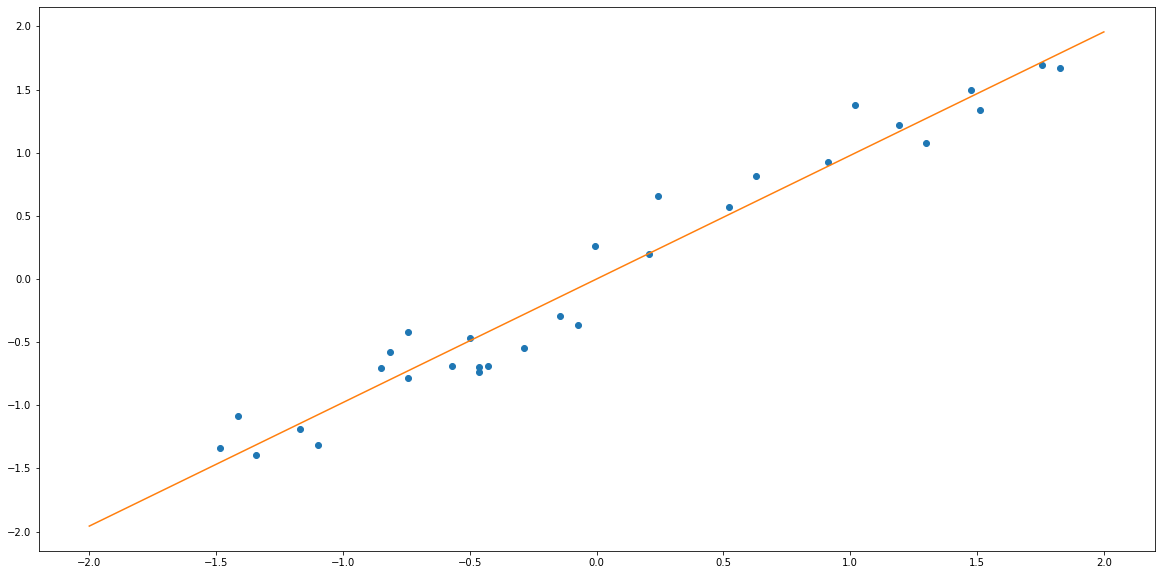

In [2871]:
x = np.linspace(-2, 2, 100)
plt.plot(years, salary, 'o')
plt.plot(x, b.data[0] * x + a.data[0])

In [2872]:
def f_normalized(x, idxs):
    res = 0
    for i in idxs:
        res += (x[0] * years_simple[i] + x[1] - salary_simple[i]) ** 2
    return res


def draw_normalized(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(-2, 2, 100)
    ax1.plot(years, salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-1, 2.5, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_normalized(torch.tensor(X), range(0, 30)),
                levels=sorted([f_normalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')

In [2873]:
def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


def partial3(f, i, x, idxs):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad3(f, x, idxs):
    return [partial3(f, i, x, idxs) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    idxs = random.sample(range(0, 30), batch)
    return grad3(func, x, idxs)


def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    loss_list = list()
    for i in range(1, epoch):

        yhat = x[1] + x[0] * years
        error = salary - yhat
        loss = (error ** 2).mean()
        loss_list.append(loss.data)

        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points[i] = x

    return np.array(points), np.array(loss_list)


def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=30):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=batch)

In [2874]:
points, loss_list44 = sgd(f_normalized, 0.03, [1, 1], lr_strategy=exp_lr, epoch=30, batch=30)

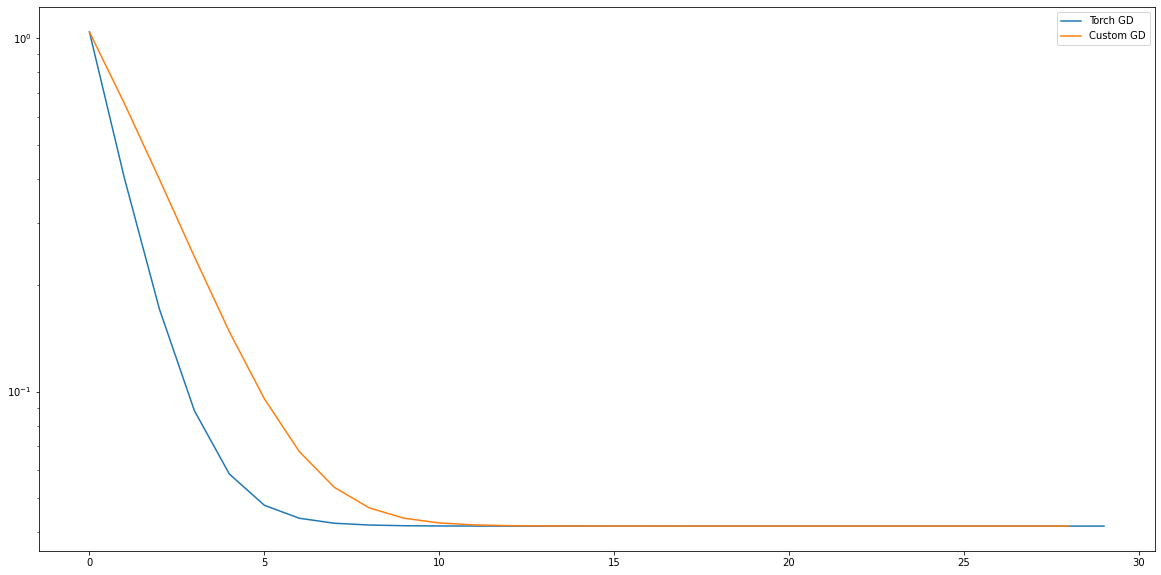

In [2875]:
plt.plot(range(len(loss_list)), loss_list, label='Torch GD')
plt.plot(range(len(loss_list44)), loss_list44, label='Custom GD')
plt.yscale('log')
plt.legend()

In [2876]:
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

batch=15

optimizer = optim.SGD([a, b], lr=0.2)


loss_list = list()
grads_list = list()

for epoch in range(30):

    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)

    idxs = random.sample(range(0, 30), batch)

    years_sample = torch.tensor([years[index] for index in idxs])
    salary_sample = torch.tensor([salary[index] for index in idxs])

    yhat_sample = a + b * years_sample
    error_sample = salary_sample - yhat_sample
    loss_sample = (error_sample ** 2).mean()

    loss_sample.backward()

    optimizer.step()
    grads_list.append(np.linalg.norm([a.grad, b.grad]))

    optimizer.step()
    grads_list.append(np.linalg.norm([a.grad, b.grad]))
    optimizer.zero_grad()

In [2877]:
points, loss_list44 = sgd(f_normalized, 0.03, [1, 1], lr_strategy=exp_lr, epoch=30, batch=15)

In [2878]:
loss_list

[tensor(1.0421),
 tensor(0.0924),
 tensor(0.0459),
 tensor(0.0416),
 tensor(0.0423),
 tensor(0.0425),
 tensor(0.0427),
 tensor(0.0434),
 tensor(0.0429),
 tensor(0.0436),
 tensor(0.0417),
 tensor(0.0420),
 tensor(0.0437),
 tensor(0.0430),
 tensor(0.0427),
 tensor(0.0439),
 tensor(0.0419),
 tensor(0.0437),
 tensor(0.0443),
 tensor(0.0419),
 tensor(0.0419),
 tensor(0.0440),
 tensor(0.0417),
 tensor(0.0445),
 tensor(0.0441),
 tensor(0.0436),
 tensor(0.0432),
 tensor(0.0419),
 tensor(0.0428),
 tensor(0.0459)]

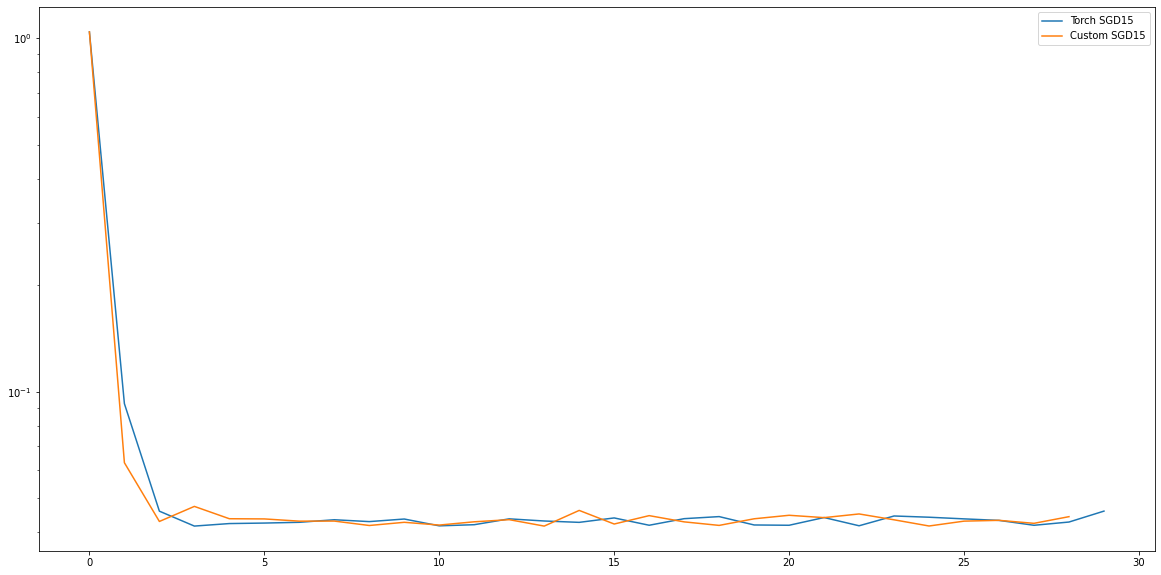

In [2879]:
plt.plot(range(len(loss_list)), loss_list, label='Torch SGD15')
plt.plot(range(len(loss_list44)), loss_list44, label='Custom SGD15')
plt.yscale('log')
plt.legend()

# Adam

In [2880]:
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

optimizer = optim.Adam([a, b], lr=0.2)

loss_list = list()
grads_list = list()

for epoch in range(30):
    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

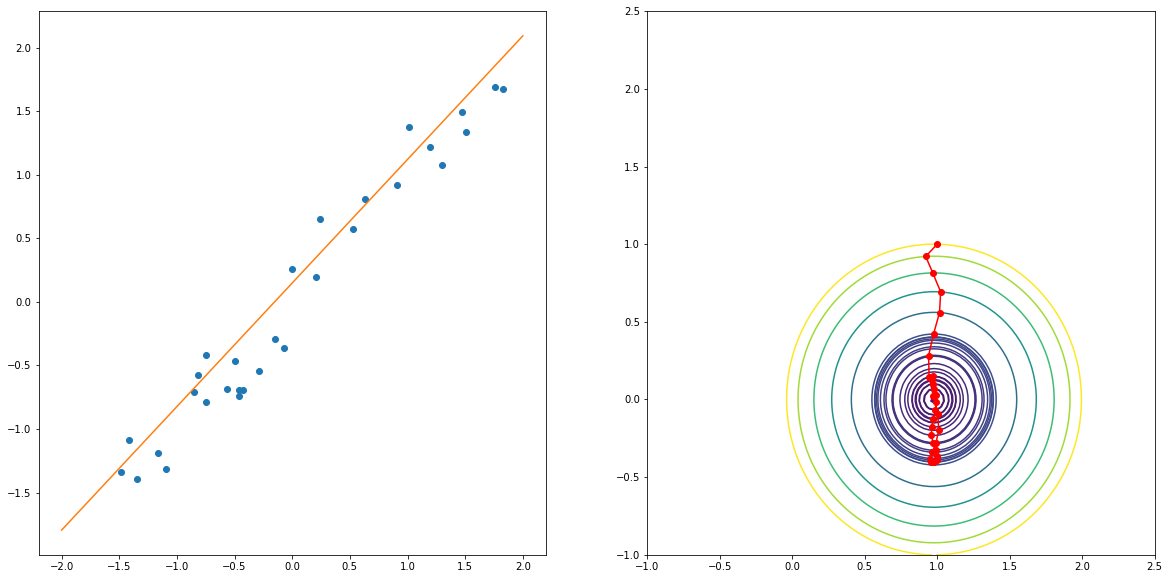

In [2881]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=30):
    x = start
    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])
    points = list()
    loss_list3 = list()
    points.append(start)
    for i in range(1, epoch):
        yhat = x[1] + x[0] * years
        error = salary - yhat
        loss = (error ** 2).mean()
        loss_list3.append(loss.data)

        gr = np.array(minibatch_grad(f, x, batch))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)

    return np.array(points), np.array(loss_list3)


points, loss_list3 = adam(f_normalized, lr=0.025, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=30)
draw_normalized(points)

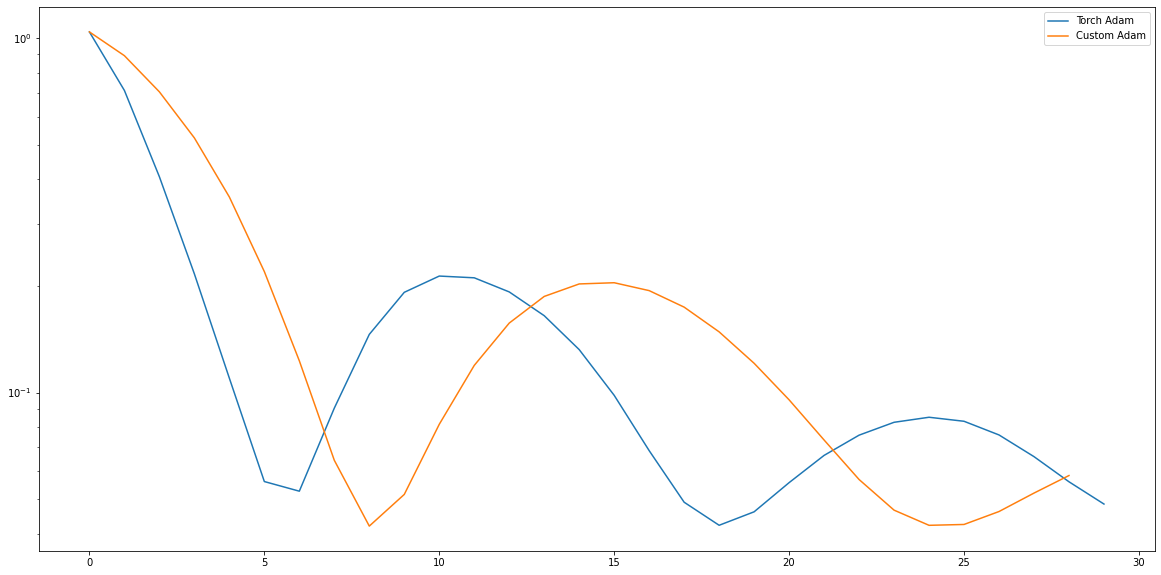

In [2882]:
plt.plot(range(len(loss_list)), loss_list, label='Torch Adam')
plt.plot(range(len(loss_list3)), loss_list3, label='Custom Adam')
plt.yscale('log')
plt.legend()

# RMSProp

In [2883]:
a = torch.tensor([1.], requires_grad=True)
b = torch.tensor([1.], requires_grad=True)

optimizer = optim.RMSprop([a, b], lr=0.2)

loss_list = list()
grads_list = list()

for epoch in range(30):
    yhat = a + b * years
    error = salary - yhat
    loss = (error ** 2).mean()
    loss_list.append(loss.data)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

In [2884]:
def rmsprop(f, b, lr, start, lr_strategy=const_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = list()
    points.append(start)
    loss_list4 = list()
    for i in range(1, epoch):
        yhat = x[1] + x[0] * years
        error = salary - yhat
        loss = (error ** 2).mean()
        loss_list4.append(loss.data)

        gr = np.array(minibatch_grad(f, x, batch))
        s = b * s + (1 - b) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points.append(x)

    return np.array(points), loss_list4


points, loss_list4 = rmsprop(f_normalized, lr=0.2, b=0.2, lr_strategy=const_lr, start=[1, 1], epoch=30)

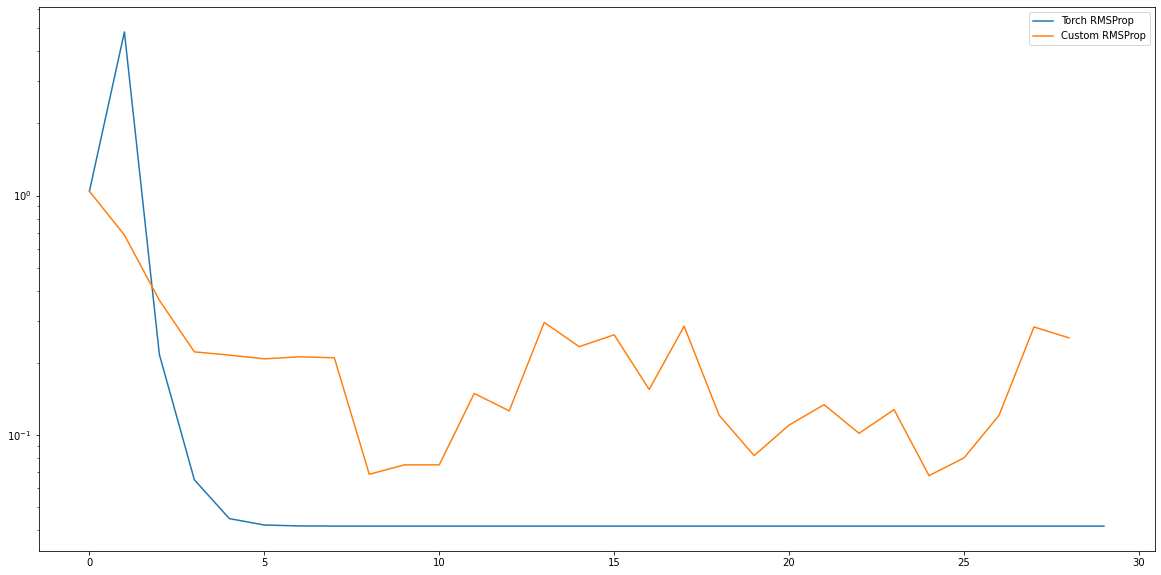

In [2885]:
plt.plot(range(len(loss_list)), loss_list, label='Torch RMSProp')
plt.plot(range(len(loss_list4)), loss_list4, label='Custom RMSProp')
plt.yscale('log')
plt.legend()

## SciPy

In [2886]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

In [2887]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

start_point = [2, 4, 5]

In [2888]:
def gradient_func1(x):
    return np.array(minibatch_grad(minimizing_func, x))


def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def minibatch_grad(func, x, batch=30):
    return grad(func, x)


def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])


def bfgs(f, grad_with_fixed_func, start, epoch):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(x)

    I = np.eye(len(x))
    H = I

    gr = grad(f, x)
    loss.append(f(x))

    grads.append(np.linalg.norm(gr))
    for i in range(1, epoch):

        p = - H @ gr

        coef = opt.line_search(f, grad_with_fixed_func, x, p)[0]

        new_x = x + coef * p

        s = new_x - x
        x = new_x
        new_grad = grad(f, x)
        grads.append(np.linalg.norm(new_grad))
        loss.append(f(x))
        points.append(x)
        y = new_grad - gr

        if np.linalg.norm(grad(f, x)) < 1e-6:
            break

        gr = new_grad

        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y, (len(x), 1))
        s = np.reshape(s, (len(x), 1))

        ro = 1.0 / (y.T @ s)
        H = (I - ro * s @ y.T) @ H @ (I - ro * y @ s.T) + ro * s @ s.T

    return [points, grads, loss]

In [2889]:
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)

In [2890]:
def minimizing_func_tensor(b):
    res = torch.tensor([0.])
    for i in range(100):
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res


def func_with_grad(pars):
    pars = torch.tensor(pars, requires_grad=True)
    y = minimizing_func_tensor(pars)
    res = y.sum()
    res.backward()
    return res.data.cpu().numpy(), pars.grad.data.cpu().numpy()


def hes(pars):
    pars = torch.tensor(pars)
    return hessian(minimizing_func_tensor, pars)


def getLoss(x):
    return minimizing_func(x)


start_point = [2, 4, 5]

loss_list = list()
loss_list.append(getLoss(start_point))
opt_res = opt.minimize(func_with_grad, start_point, method='BFGS', jac=True,
                       callback=lambda xk: loss_list.append(getLoss(xk)))

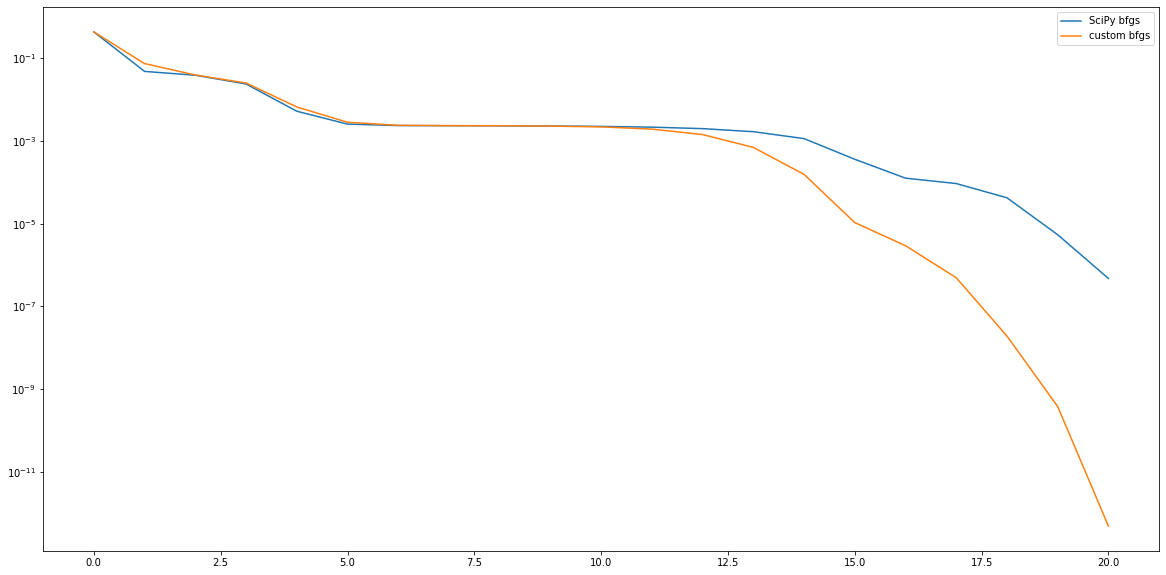

In [2891]:
size = min(len(loss_list), len(bfgs_loss))
plt.plot(range(size), loss_list[:size], label='SciPy bfgs')
plt.plot(range(size), bfgs_loss[:size], label='custom bfgs')
plt.yscale('log')
plt.legend()

In [2892]:
opt.minimize(func_with_grad, start_point, method='dogleg', jac=True, hess=hes,
             callback=lambda xk: loss_list.append(getLoss(xk))).message

'A linalg error occurred, such as a non-psd Hessian.'

# Least Squares

In [2893]:
func5 = lambda b: np.e ** (-b[0] * xs) / (b[1] + b[2] * xs) - ys
start_point = [2, 4, 5]
opt.least_squares(func5, start_point)
# print("Least squares res:", res.x)

 active_mask: array([0., 0., 0.])
        cost: 2.221544464407143e-23
         fun: array([1.35558231e-13, 2.05446771e-13, 3.16080495e-13, 4.42812453e-13,
       5.71320768e-13, 6.93556323e-13, 8.05133737e-13, 9.03804809e-13,
       9.88958915e-13, 1.06070708e-12, 1.11960441e-12, 1.16667787e-12,
       1.20287114e-12, 1.22932220e-12, 1.24698862e-12, 1.25693900e-12,
       1.26011701e-12, 1.25741084e-12, 1.24955601e-12, 1.23732968e-12,
       1.22132859e-12, 1.20217725e-12, 1.18040300e-12, 1.15640830e-12,
       1.13063725e-12, 1.10343679e-12, 1.07515385e-12, 1.04602438e-12,
       1.01629816e-12, 9.86204174e-13, 9.55922841e-13, 9.25599875e-13,
       8.95384461e-13, 8.65391092e-13, 8.35716912e-13, 8.06438250e-13,
       7.77641840e-13, 7.49393603e-13, 7.21728233e-13, 6.94676955e-13,
       6.68291811e-13, 6.42583209e-13, 6.17578905e-13, 5.93294511e-13,
       5.69724823e-13, 5.46873311e-13, 5.24750382e-13, 5.03349099e-13,
       4.82664256e-13, 4.62683711e-13, 4.43400525e-13, 4.2481122

# Bounds

In [2894]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)
start_point = [2, 4, 5]

def getLoss(x):
    return minimizing_func(x)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 2.24295549e-01, -1.57082129e-03, -1.27932639e+00],
       [-5.18591782e-12, -2.01948214e-12,  4.38087766e-11]])
     fun: 0.0008513534392092058
 message: 'Optimization terminated successfully.'
    nfev: 507
     nit: 6
  status: 0
 success: True
       x: array([0.83180159, 1.93401984, 4.        ])


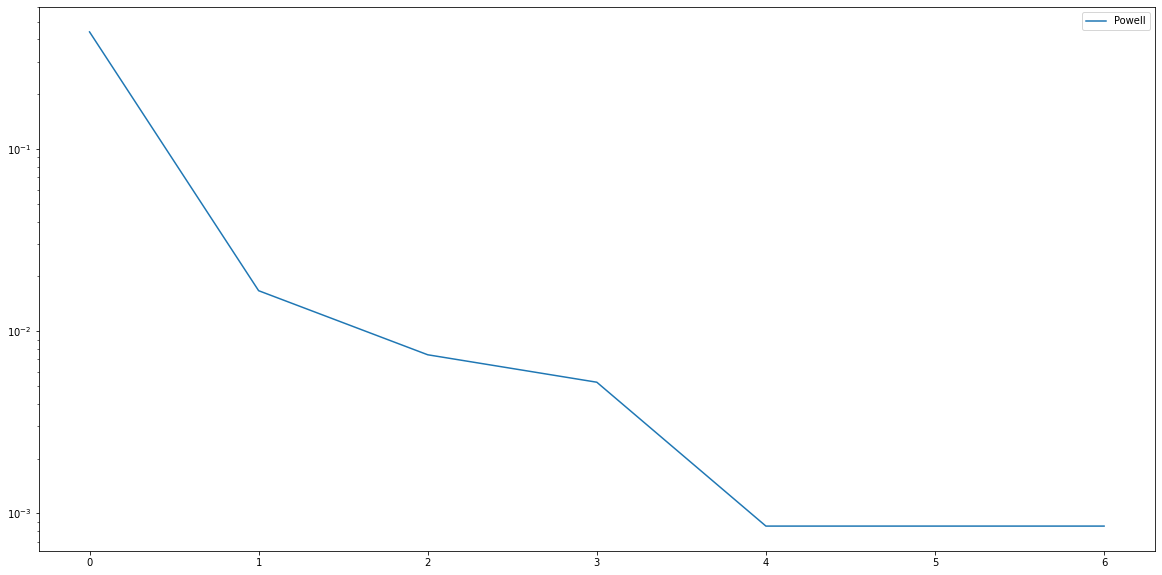

In [2895]:
loss_list = list()
loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func, bounds=[(-10, 10), (1, 5), (4, 6)], tol=1e-5, x0=start_point, method='Powell',
                   callback=lambda xk: loss_list.append(getLoss(xk)))

plt.plot(range(len(loss_list)), loss_list, label='Powell')
plt.legend()
plt.yscale('log')
print(res)

      fun: 0.0007672291851158321
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.35704901e-05, -1.26288737e-05,  1.57839315e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 15
     njev: 22
   status: 0
  success: True
        x: array([0.81255123, 1.95187061, 4.        ])


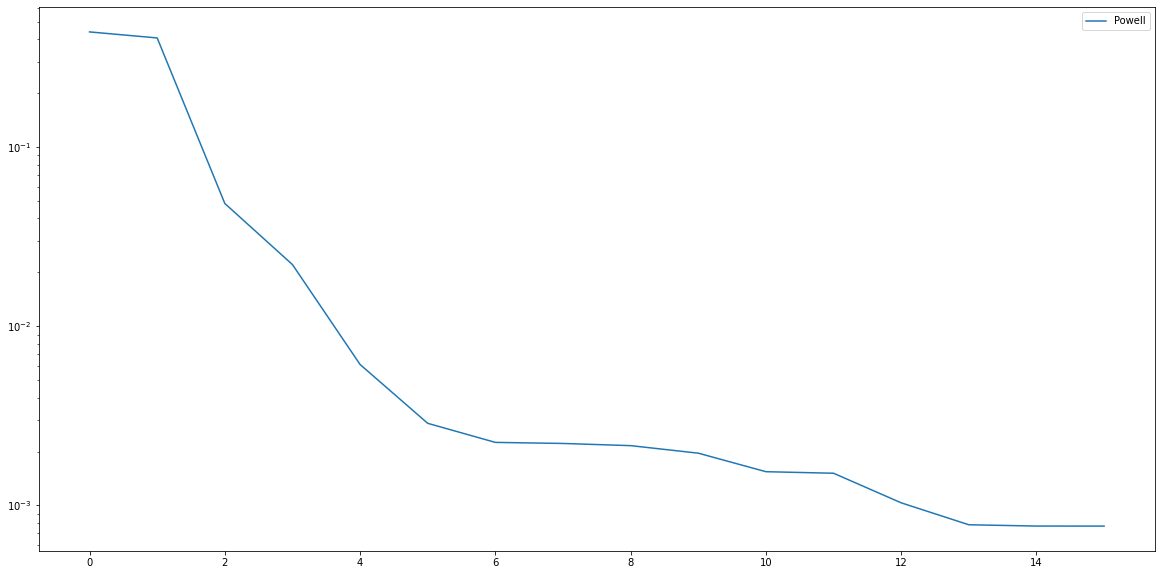

In [2896]:
loss_list = list()
loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func, bounds=[(-10, 10), (1, 5), (4, 6)], tol=1e-5, x0=start_point, method='L-BFGS-B',
                   callback=lambda xk: loss_list.append(getLoss(xk)))

plt.plot(range(len(loss_list)), loss_list, label='Powell')
plt.legend()
plt.yscale('log')
print(res)

 final_simplex: (array([[0.81260512, 1.9518819 , 4.        ],
       [0.81261044, 1.95187688, 4.        ],
       [0.81261121, 1.95187707, 4.        ],
       [0.81260851, 1.95188457, 4.        ]]), array([0.00076723, 0.00076723, 0.00076723, 0.00076723]))
           fun: 0.0007672284739942837
       message: 'Optimization terminated successfully.'
          nfev: 157
           nit: 87
        status: 0
       success: True
             x: array([0.81260512, 1.9518819 , 4.        ])


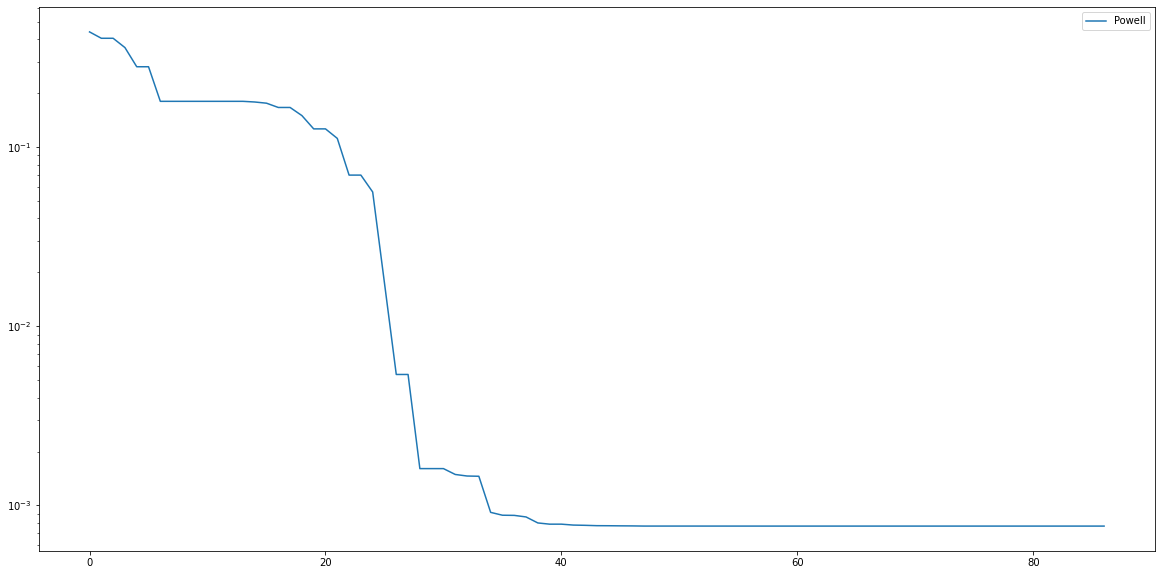

In [2897]:
loss_list = list()
loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func, bounds=[(-10, 10), (1, 5), (4, 6)], tol=1e-5, x0=start_point, method='Nelder-Mead',
                   callback=lambda xk: loss_list.append(getLoss(xk)))

plt.plot(range(len(loss_list)), loss_list, label='Powell')
plt.legend()
plt.yscale('log')
print(res)

# Constrains

In [2898]:
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint

nonLinearConstraint = lambda x: x[0] - np.sin(x[1])

nlc = NonlinearConstraint(nonLinearConstraint, lb=-10, ub=10)
lc = LinearConstraint([4, 3, 2], lb=-10, ub=10)

     fun: 6.727976414177103e-07
     jac: array([1.88563235e-04, 7.29264802e-04, 6.81623733e-05])
 message: 'Optimization terminated successfully'
    nfev: 87
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([1.0004327 , 2.00212064, 2.99583862])


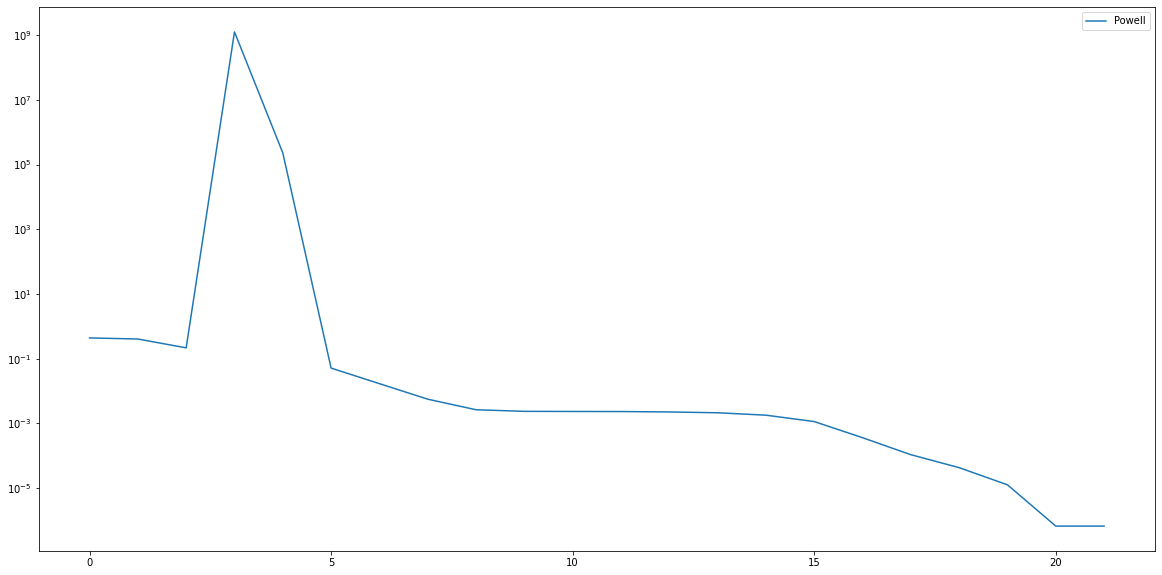

In [2899]:
loss_list = list()
loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func,  constraints=nlc, tol=1e-5, x0=start_point, method='SLSQP', callback=lambda xk: loss_list.append(getLoss(xk)))

plt.plot(range(len(loss_list)), loss_list, label='Powell')
plt.legend()
plt.yscale('log')
print(res)

     fun: 0.3994323358957395
     jac: array([-1.22528219, -0.91896014, -0.61267613])
 message: 'Optimization terminated successfully'
    nfev: 87
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([1.02838608, 1.90251143, 0.0894607 ])


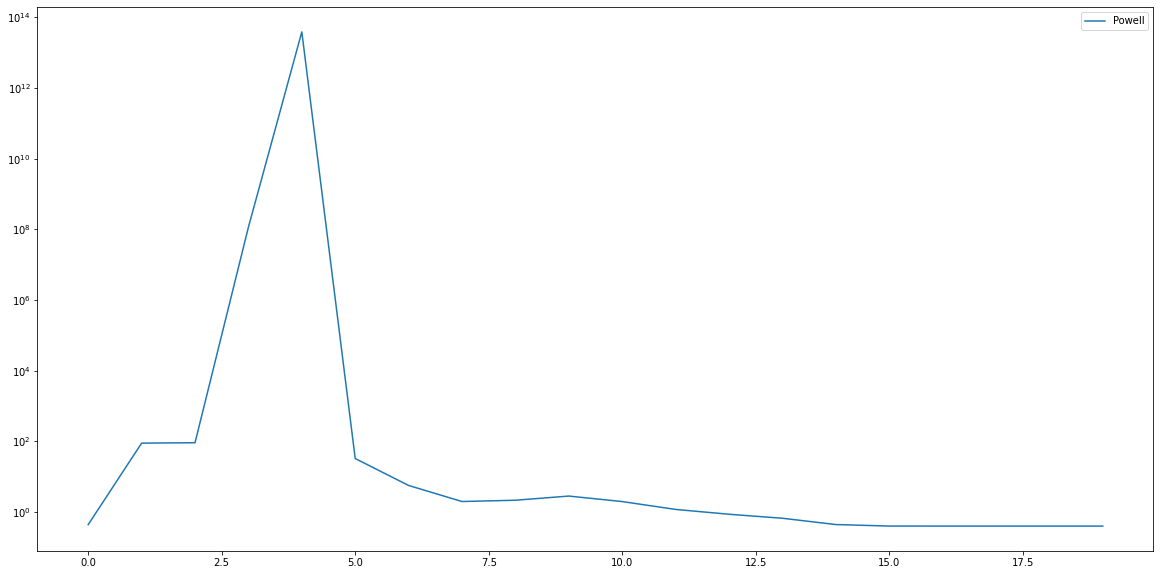

In [2900]:
loss_list = list()
loss_list.append(getLoss(start_point))
res = opt.minimize(minimizing_func,  constraints=lc, tol=1e-6, x0=start_point, method='SLSQP',
                   callback=lambda xk: loss_list.append(getLoss(xk)))

plt.plot(range(len(loss_list)), loss_list, label='Powell')
plt.legend()
plt.yscale('log')
print(res)